In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [8]:
# Use the Base class to reflect the database tables into ORM classes
Base.prepare(engine, reflect=True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Assign the classes to a variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create a session (link) from Python to the DB
session = Session(engine)

In [12]:
# Display the row's columns and data in dictionary format
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2409783dd48>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [13]:
station_first_row = session.query(Station).first()
station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2409783d108>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

# Exploratory Climate Analysis

In [56]:
# Retrieve the last 12 months of precipitation data and plot the results

# Total dates from the Measurement class
session.query(func.count(Measurement.date)).all()

[(19550)]

In [57]:
# Query the latest date 
latest_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date_query

('2017-08-23')

In [58]:
# Extract string from query object
latest_date_string = np.ravel(latest_date_query)[0]
latest_date_string

'2017-08-23'

In [59]:
# Convert string to datetime using strptime()
latest_date_dt = dt.datetime.strptime(latest_date_string, '%Y-%m-%d')
latest_date_dt

datetime.datetime(2017, 8, 23, 0, 0)

In [60]:
# Parse out the year, month and day from the datetime object
latest_year = dt.datetime.strftime(latest_date_dt, '%Y')
latest_month = dt.datetime.strftime(latest_date_dt, '%m')
latest_day = dt.datetime.strftime(latest_date_dt, '%d')

In [61]:
# Calculate the date 1 year ago from the last data point in the database
year_before_date = dt.date(int(latest_year), int(latest_month), int(latest_day)) - dt.timedelta(days=365)
year_before_date

datetime.date(2016, 8, 23)

In [104]:
# Query the last 12 months of precipitation data
precipitation_data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date >= year_before_date)
                  .order_by(Measurement.date)
                  .all())

In [105]:
# Convert query object to Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data)
precipitation_df.head(3)

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05


In [106]:
# Set the index to the date column andsort dataframe by date
sorted_precipitation_df = precipitation_df.set_index('date').sort_index(ascending = True)
sorted_precipitation_df.head(3)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05


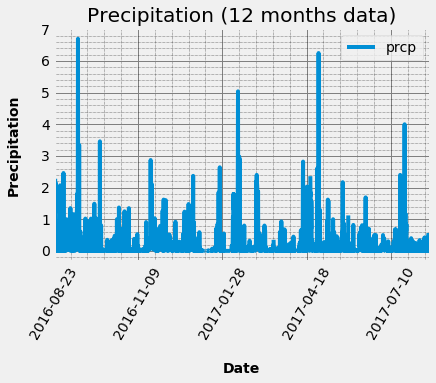

In [107]:
# Plotting the results
fig, ax = plt.subplots()

sorted_precipitation_df.plot(title = "Precipitation (12 months data)", ax=ax)

ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='1', color='grey')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax.set_ylabel("Precipitation", labelpad=20, weight='bold', size=14)
ax.set_xlabel("Date", labelpad=20, weight='bold', size=14)

plt.xticks(rotation=60)
plt.show()

In [108]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [109]:
# Design a query to show how many stations are available in this dataset?

session.query(func.count(Station.id)).all()

[(9)]

In [110]:
station_list = session.query(Measurement.station).group_by(Measurement.station).all()
station_list

[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [111]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_station = active_stations[0]
most_active_station

('USC00519281', 2772)

In [120]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest_temp_active_station = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()

highest_temp_active_station = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()

average_temp_active_station = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()

print(f"Lowest Temperature: {lowest_temp_active_station[0][0]}\nHighest Temperature: {highest_temp_active_station[0][0]}\nAverage Temperature: {round((average_temp_active_station[0][0]),1)}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.7


In [121]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs_data = (session.query(Measurement.tobs)
                .filter(Measurement.date >= year_before_date)
                .filter(Measurement.station == most_active_station[0])
                .all())

In [124]:
# Convert query object to Pandas DataFrame
temp_obs_df = pd.DataFrame(temp_obs_data, columns = ["Temperature"])
temp_obs_df.head(3)

,Temperature
0,77.0
1,77.0
2,80.0


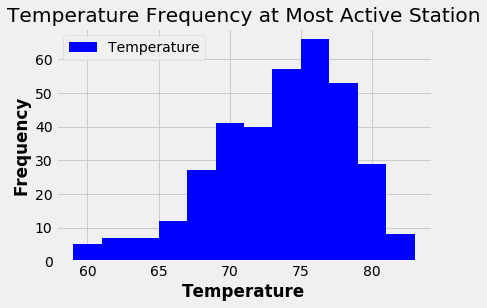

In [134]:
temp_obs_df.plot.hist(bins=12, title="Temperature Frequency at Most Active Station", color="blue", grid = True)

plt.ylabel('Frequency', weight='bold')
plt.xlabel('Temperature', weight='bold')
plt.show()

## Bonus Challenge

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
